### Importing & INstalling necessary modules

In [3]:
# !pip install wordcloud

In [5]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

### Importing Dataset

In [54]:
# Importing the dataset
DATASET_COLUMNS=['Index','Date','Target','Id','Tweet']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('Dataset.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,Index,Date,Target,Id,Tweet
196,196,2022-03-05 09:54:05+00:00,4,1.500000e+18,Samsung Galaxy A52s 5G Getting One UI Replace ...
3870,14,2022-03-28 09:58:13+00:00,4,1.508380e+18,is jisung the one with the line mic camera act...
1046,1046,2022-03-05 00:45:45+00:00,0,1.500000e+18,Aston Martin will have to show potential to ge...
1133,1133,2022-03-06 06:14:25+00:00,0,1.500000e+18,Just published episode 30 of lets talk cloud n...
2400,2400,2022-03-06 06:54:20+00:00,0,1.500000e+18,DEAD MANS SHOES


### Exploratory Data Analysis

In [55]:
df.head()

,Index,Date,Target,Id,Tweet
0,0,2022-03-06 06:31:01+00:00,0,1.500000e+18,Debunking the Skin Improvement Myth Product re...
1,1,2022-03-06 06:18:31+00:00,4,1.500000e+18,We get your concern regarding the offer of the...
2,2,2022-03-06 06:07:41+00:00,4,1.500000e+18,Thinking about buying Mr Peanut s Gold Series ...
3,3,2022-03-06 06:07:36+00:00,4,1.500000e+18,Thinking about buying Mr Peanut s Gold Series ...
4,4,2022-03-06 06:00:08+00:00,0,1.500000e+18,Clinical Pathology Interpretations Fourth Edit...


In [56]:
df.columns

Index(['Index', 'Date', 'Target', 'Id', 'Tweet'], dtype='object')

In [57]:
print('length of data is', len(df))

length of data is 5077


In [58]:
df.shape

(5077, 5)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5077 entries, 0 to 5076
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   5077 non-null   int64  
 1   Date    5077 non-null   object 
 2   Target  5077 non-null   int64  
 3   Id      5077 non-null   float64
 4   Tweet   5076 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 198.4+ KB


In [60]:
df.dtypes

Index       int64
Date       object
Target      int64
Id        float64
Tweet      object
dtype: object

In [61]:
np.sum(df.isnull().any(axis=1))

1

In [62]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   5
Count of rows in the data is:   5077


In [63]:
df['Target'].unique()

array([0, 4], dtype=int64)

In [64]:
df['Target'].nunique()

2

### Data Visualization

In [65]:
ax = df.groupby('Target').count()
print(ax)

        Index  Date    Id  Tweet
Target                          
0        3150  3150  3150   3149
4        1927  1927  1927   1927


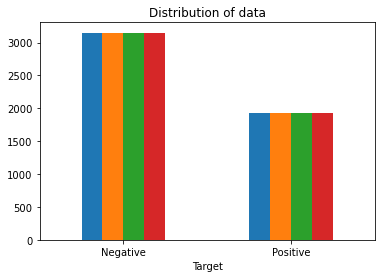

In [66]:
# Plotting the distribution for dataset.
ax = df.groupby('Target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['Tweet']), list(df['Target'])

<AxesSubplot:xlabel='Target', ylabel='count'>

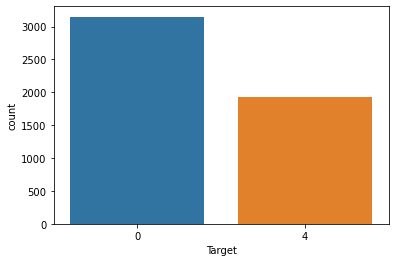

In [67]:
import seaborn as sns
sns.countplot(x='Target', data=df)

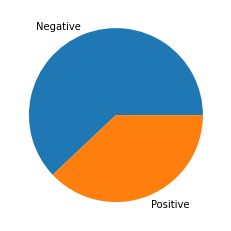

In [68]:
#we can add explode parameter to pop out the different sections of our pie chart
#remove explode parameter for a normal pie chart

ax = df.groupby('Target').count()
plt.pie(ax['Index'], labels = ['Negative', 'Positive'])
plt.show()

### Data Preprocessing

In [69]:
data=df[['Target', 'Tweet']]

In [70]:
data['Target'] = data['Target'].replace(4,1)

<ipython-input-70-0676ffdaeefb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = data['Target'].replace(4,1)


In [71]:
data['Target'].unique()

array([0, 1], dtype=int64)

In [72]:
data_neg = data[data['Target'] == -1]
data_pos = data[data['Target'] == 1]

In [74]:
dataset = pd.concat([data_neg, data_pos])

In [75]:
dataset['Tweet']=dataset['Tweet'].str.lower()
dataset['Tweet'].tail()

5062       i got literal plot armor superman lmao lets go
5064    thoughts on will smith congrats on winning osc...
5068    fake news from the news portals that considers...
5069    lmao his wife that paragon of virture virtue r...
5075    and it was surreal listening to him make richa...
Name: Tweet, dtype: object

#### Defining Stopwords

In [76]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

#### Removing Stopwords from Dataset

In [77]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['Tweet'] = dataset['Tweet'].apply(lambda text: cleaning_stopwords(text))
dataset['Tweet'].head()

1     get concern regarding offer product pricing of...
2     thinking buying mr peanut gold series airline ...
3     thinking buying mr peanut gold series airline ...
10    glad found superfocus supplement help improve ...
34    would love try plant based milk try free share...
Name: Tweet, dtype: object

#### Removing Punctuations 

In [78]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['Tweet']= dataset['Tweet'].apply(lambda x: cleaning_punctuations(x))
dataset['Tweet'].tail()

5062         got literal plot armor superman lmao lets go
5064    thoughts smith congrats winning oscar much har...
5068    fake news news portals considers paragon free ...
5069    lmao wife paragon virture virtue running crips...
5075    surreal listening make richard williams parago...
Name: Tweet, dtype: object

#### Removing repeating characters

In [79]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['Tweet'] = dataset['Tweet'].apply(lambda x: cleaning_repeating_char(x))
dataset['Tweet'].tail()

5062         got literal plot armor superman lmao lets go
5064    thoughts smith congrats winning oscar much har...
5068    fake news news portals considers paragon free ...
5069    lmao wife paragon virture virtue running crips...
5075    surreal listening make richard williams parago...
Name: Tweet, dtype: object

#### Removing Urls from dataset

In [80]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['Tweet'] = dataset['Tweet'].apply(lambda x: cleaning_URLs(x))
dataset['Tweet'].tail()

5062         got literal plot armor superman lmao lets go
5064    thoughts smith congrats winning oscar much har...
5068    fake news news portals considers paragon free ...
5069    lmao wife paragon virture virtue running crips...
5075    surreal listening make richard williams parago...
Name: Tweet, dtype: object

In [81]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['Tweet'] = dataset['Tweet'].apply(lambda x: cleaning_numbers(x))
dataset['Tweet'].tail()

5062         got literal plot armor superman lmao lets go
5064    thoughts smith congrats winning oscar much har...
5068    fake news news portals considers paragon free ...
5069    lmao wife paragon virture virtue running crips...
5075    surreal listening make richard williams parago...
Name: Tweet, dtype: object

#### Tokenizing Tweets

In [82]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer("[\w']+")
dataset['Tweet'] = dataset['Tweet'].apply(tokenizer.tokenize)
dataset['Tweet'].head()

1     [get, concern, regarding, offer, product, pric...
2     [thinking, buying, mr, peanut, gold, series, a...
3     [thinking, buying, mr, peanut, gold, series, a...
10    [glad, found, superfocus, supplement, help, im...
34    [would, love, try, plant, based, milk, try, fr...
Name: Tweet, dtype: object

#### Applying Stemming Technique

In [83]:
import nltk
# !nltk.download('wordnet')
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['Tweet']= dataset['Tweet'].apply(lambda x: stemming_on_text(x))
dataset['Tweet'].head()

1     [get, concern, regarding, offer, product, pric...
2     [thinking, buying, mr, peanut, gold, series, a...
3     [thinking, buying, mr, peanut, gold, series, a...
10    [glad, found, superfocus, supplement, help, im...
34    [would, love, try, plant, based, milk, try, fr...
Name: Tweet, dtype: object

In [84]:
#import nltk
#nltk.download('wordnet')

#### Lemmatizing

In [85]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['Tweet'] = dataset['Tweet'].apply(lambda x: lemmatizer_on_text(x))
dataset['Tweet'].head()

1     [get, concern, regarding, offer, product, pric...
2     [thinking, buying, mr, peanut, gold, series, a...
3     [thinking, buying, mr, peanut, gold, series, a...
10    [glad, found, superfocus, supplement, help, im...
34    [would, love, try, plant, based, milk, try, fr...
Name: Tweet, dtype: object

In [86]:
X=data.Tweet
y=data.Target

#### Cloud of negative words

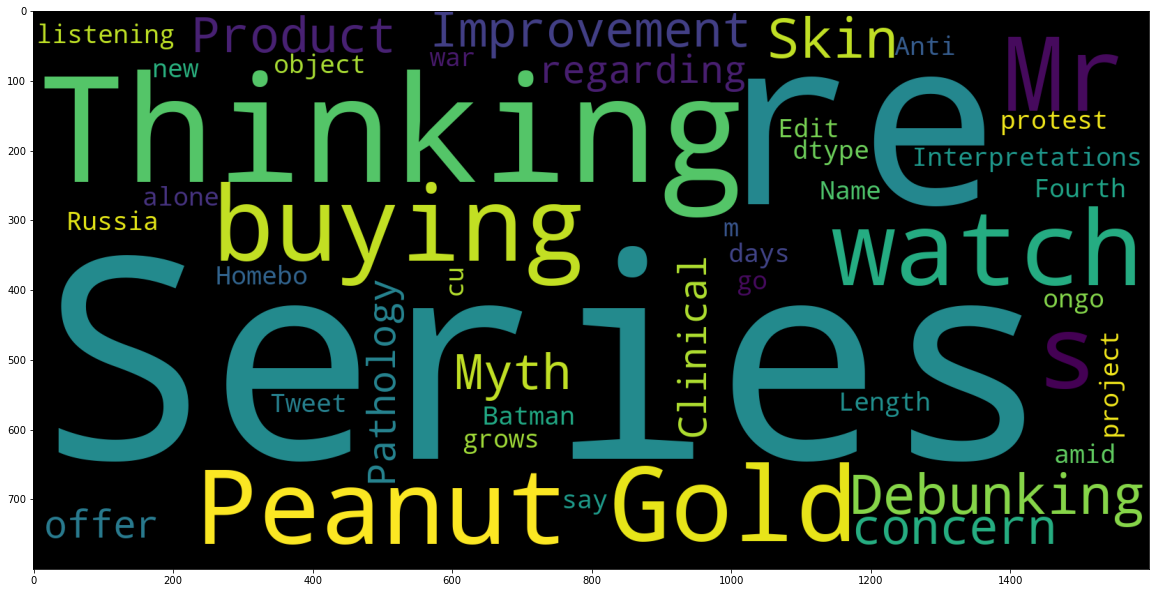

In [87]:
data_neg = data['Tweet'][:3150]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate("".join(str(data_neg)))
plt.imshow(wc)

#### World Cloud of Positive Words

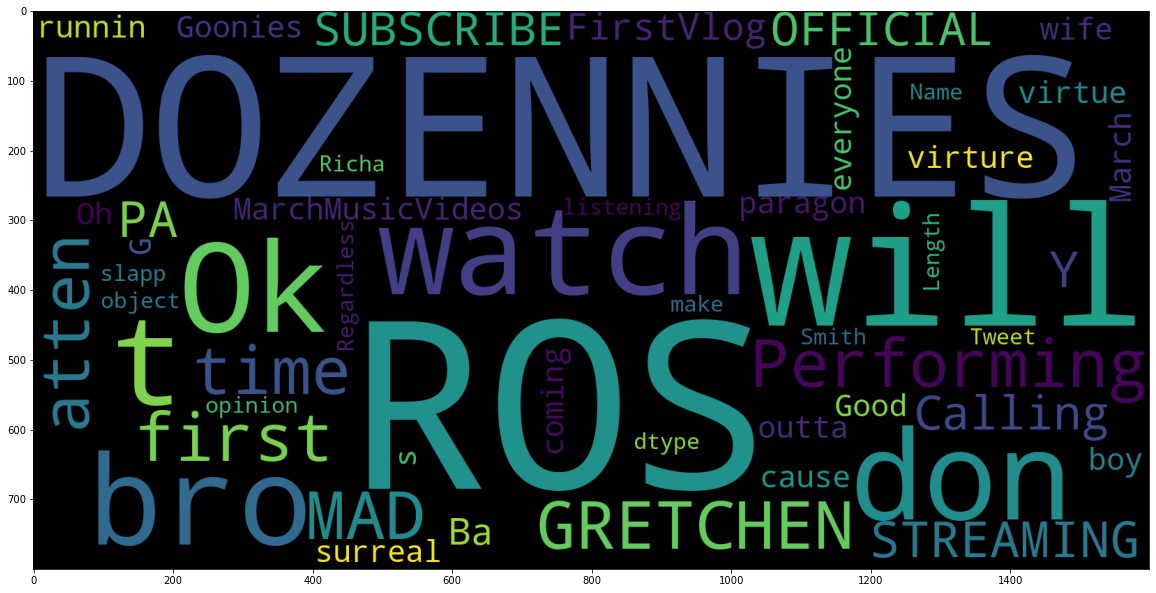

In [88]:
data_pos = data['Tweet'][3151:5077]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate("".join(str(data_pos)))
plt.figure(figsize = (20,20))
plt.imshow(wc)

### Splitting dataset into Train and Test Subset

In [89]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =11000)

### TF-IDF vectorization to dataset

In [90]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=6000)
vectoriser.fit(X_train.values.astype('U'))
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  6000


In [91]:
X_train = vectoriser.transform(X_train.values.astype('U'))
X_test  = vectoriser.transform(X_test.values.astype('U'))

### Model Evolution Function

Accuracy Score

Confusion Matrix with Plot

ROC-AUC(Area Under the Curve) Curve

In [92]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Neutral','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Model Building

### Model 1 - Bernoulli Naive Bayes

              precision    recall  f1-score   support

           0       0.77      0.86      0.81       156
           1       0.72      0.59      0.65        98

    accuracy                           0.76       254
   macro avg       0.75      0.73      0.73       254
weighted avg       0.75      0.76      0.75       254



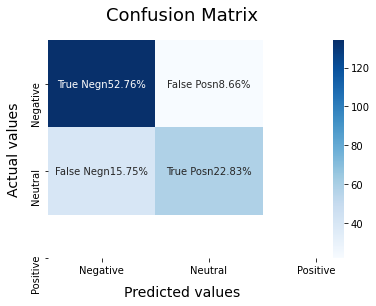

In [93]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

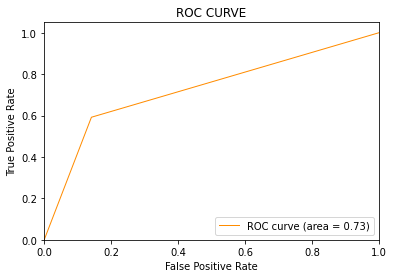

In [94]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Model 2 - SVM (Support Vector Machine)

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       156
           1       0.88      0.74      0.81        98

    accuracy                           0.86       254
   macro avg       0.87      0.84      0.85       254
weighted avg       0.86      0.86      0.86       254



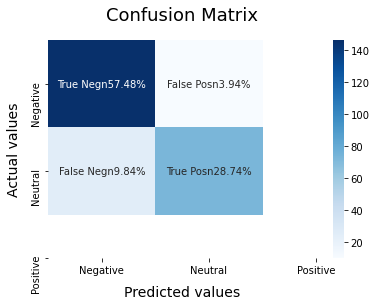

In [95]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

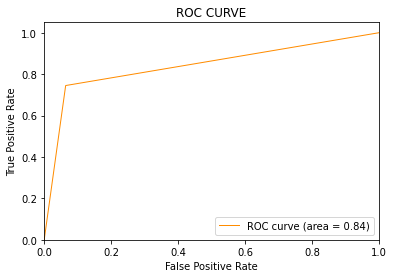

In [96]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Model 3 - Logistic Regression

              precision    recall  f1-score   support

           0       0.78      0.94      0.85       156
           1       0.85      0.59      0.70        98

    accuracy                           0.80       254
   macro avg       0.82      0.76      0.78       254
weighted avg       0.81      0.80      0.79       254



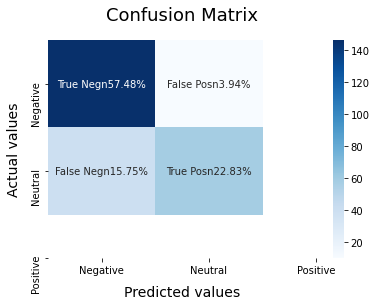

In [97]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

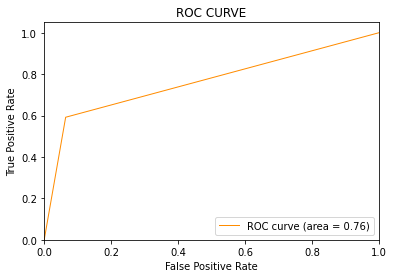

In [98]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Conclusion

### Accuracy: 
   As far as the accuracy of the model is concerned **Support Vector Machine (SVM)** performs better than **Logistic Regression** which in turn performs better than **Bernoulli Naive Bayes**.

F1-score: The F1 Scores for class 0 and class 1 are :

    (a) For class 0: Bernoulli Naive Bayes(accuracy = 0.81) < Logistic Regression (accuracy = 0.85) < SVM (accuracy =0.89)
    (b) For class 1: Bernoulli Naive Bayes (accuracy = 0.65) < Logistic Regression (accuracy = 0.70) < SVM (accuracy = 0.81)

AUC Score: All three models have the same ROC-AUC score.

We, therefore, conclude that the **SVM (Support Vector Machine)** is the best model for the above-given dataset.